In [1]:
import pybliss

import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt


In [2]:
data_loc = "/datasets/nathan/datasets/voyager_2020_data/"


In [3]:

# cadence = pybliss.cadence([[f"{data_loc}/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5",
#                     f"{data_loc}/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5",
#                     f"{data_loc}/single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5"
#                     ],
#                     [f"{data_loc}/single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5"],
#                     [f"{data_loc}/single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5"],
#                     [f"{data_loc}/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5"]])

obs = pybliss.observation_target([f"{data_loc}/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"])
# obs = pybliss.observation_target([f"{data_loc}/single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5"])
#                     
# obs = pybliss.observation_target([f"{data_loc}/single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016.rawspec.0000.h5"])


In [4]:


obs = pybliss.flaggers.flag_filter_rolloff(obs, .2)

obs = pybliss.flaggers.flag_spectral_kurtosis(obs, .02, 15)



spec kurtosis with M=16 and N=51


In [5]:
noise_est_options = pybliss.estimators.noise_power_estimate_options()
noise_est_options.masked_estimate = True
noise_est_options.estimator_method = pybliss.estimators.noise_power_estimator.stddev
obs = pybliss.estimators.estimate_noise_power(obs, noise_est_options)

noise_stats = obs.scans[0].noise_estimate

print(f"noise floor of spectrum (estimated with rfi mask): \t{noise_stats.noise_floor/1e6:1.4f}")
print(f"noise power of spectrum (estimated with rfi mask): \t{noise_stats.noise_power/1e6:1.4e}")
print("---")


noise floor of spectrum (estimated with rfi mask): 	5.1841
noise power of spectrum (estimated with rfi mask): 	4.2146e+05
---


In [6]:
opts = pybliss.integrate_drifts_options()
opts.desmear = False
opts.low_rate = -48
opts.high_rate = 48
opts.rate_step_size = 1

dedrift = pybliss.drift_search.integrate_drifts(obs, opts)

# TODO: with desmear = True, there's an error in addition

We're doing cpu version


/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/usr/local/lib/python3.10/dist-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/tmp/ipykernel_1435/4193304716.py:14: RuntimeWarning: divide by zero encountered in log10
  ax3.imshow(np.log10(doppler_spectrum[:, :]), aspect="auto", interpolation=None, cmap="turbo")


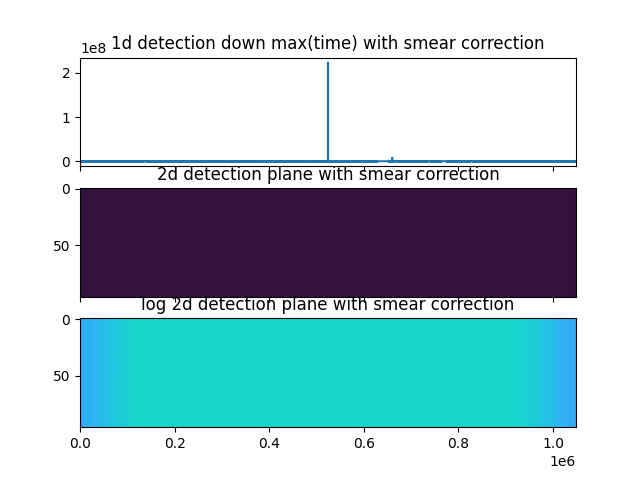

In [7]:
doppler_spectrum = np.from_dlpack(dedrift.scans[0].doppler_spectrum())
spectrum = np.from_dlpack(dedrift.scans[0].data)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.set_title("1d detection down max(time) with smear correction")
ax1.plot(spectrum[:, :].max(0)/16)
plt.margins(0)

ax2.set_title("2d detection plane with smear correction")
ax2.imshow(doppler_spectrum[:, :], aspect="auto", interpolation=None, cmap="turbo")

ax3.set_title("log 2d detection plane with smear correction")
ax3.imshow(np.log10(doppler_spectrum[:, :]), aspect="auto", interpolation=None, cmap="turbo")



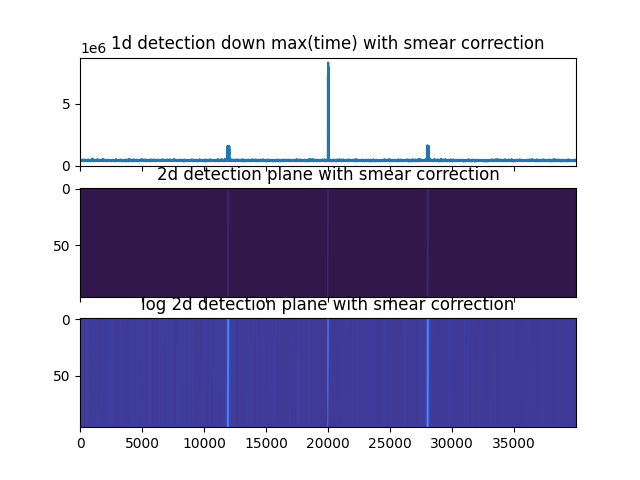

In [8]:
start = 640000
stop = 680000

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True)

ax1.set_title("1d detection down max(time) with smear correction")
ax1.plot(spectrum[:, start:stop].max(0)/16)
plt.margins(0)

ax2.set_title("2d detection plane with smear correction")
ax2.imshow(doppler_spectrum[:, start:stop], aspect="auto", interpolation=None, cmap="turbo")

ax3.set_title("log 2d detection plane with smear correction")
ax3.imshow(np.log10(doppler_spectrum[:, start:stop]), aspect="auto", interpolation=None, cmap="turbo")



In [9]:
doppler_plot = doppler_spectrum[:, 659950:660100]
print(doppler_plot.shape)

(96, 150)


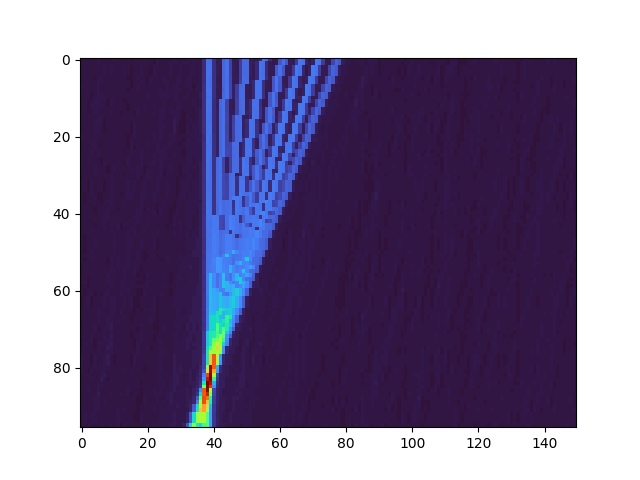

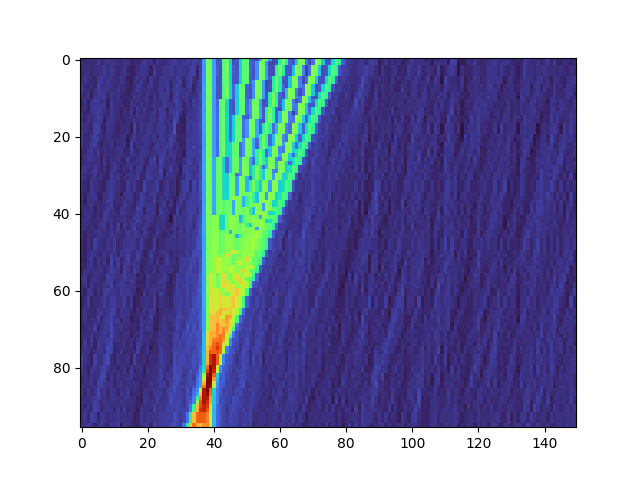

In [10]:

plt.figure()
# ax3.set_title("log 2d detection plane with smear correction")
plt.imshow((doppler_plot), aspect="auto", interpolation=None, cmap="turbo")


plt.figure()
# ax3.set_title("log 2d detection plane with smear correction")
plt.imshow(np.log10(doppler_plot), aspect="auto", interpolation=None, cmap="turbo")


In [11]:
hit_search_opts = pybliss.drift_search.hit_search_options()
hit_search_opts.method = pybliss.drift_search.hit_search_methods.local_maxima
# hit_search_opts.neighborhood = [
#                               [-1, 4],  [0, 4],  [1, 4],
#                               [-1, 3],  [0, 3],  [1, 3],
#                     [-2, 2],  [-1, 2],  [0, 2],  [1, 2],  [2, 2],
# [-4, 1],  [-3, 1],  [-2, 1],  [-1, 1],  [0, 1],  [1, 1],  [2, 1],  [3, 1],  [4, 1],
# [-4, 0],  [-3, 0],  [-2, 0],  [-1, 0],           [1, 0],  [2, 0],  [3, 0],  [4, 0],
# [-4, -1], [-3, -1], [-2, -1], [-1, -1], [0, -1], [1, -1], [2, -1], [3, -1], [4, -1],
#                     [-2, -2], [-1, -2], [0, -2], [1, -2], [2, -2],
#                               [-1, -3], [0, -3], [1, -3],
#                               [-1, -4], [0, -4], [1, -4],
# ]
hit_search_opts.neighborhood = [
    [-5, 5],  [-4, 5],  [-3, 5],  [-2, 5],  [-1, 5],  [0, 5],  [1, 5],  [2, 5],  [3, 5],  [4, 5],  [5, 5],
    [-5, 4],  [-4, 4],  [-3, 4],  [-2, 4],  [-1, 4],  [0, 4],  [1, 4],  [2, 4],  [3, 4],  [4, 4],  [5, 4],
    [-5, 3],  [-4, 3],  [-3, 3],  [-2, 3],  [-1, 3],  [0, 3],  [1, 3],  [2, 3],  [3, 3],  [4, 3],  [5, 3],
    [-5, 2],  [-4, 2],  [-3, 2],  [-2, 2],  [-1, 2],  [0, 2],  [1, 2],  [2, 2],  [3, 2],  [4, 2],  [5, 2],
    [-5, 1],  [-4, 1],  [-3, 1],  [-2, 1],  [-1, 1],  [0, 1],  [1, 1],  [2, 1],  [3, 1],  [4, 1],  [5, 1], 
    [-5, 0],  [-4, 0],  [-3, 0],  [-2, 0],  [-1, 0],           [1, 0],  [2, 0],  [3, 0],  [4, 0],  [5, 0], 
    [-5, -1], [-4, -1], [-3, -1], [-2, -1], [-1, -1], [0, -1], [1, -1], [2, -1], [3, -1], [4, -1], [5, -1],
    [-5, -2], [-4, -2], [-3, -2], [-2, -2], [-1, -2], [0, -2], [1, -2], [2, -2], [3, -2], [4, -2], [5, -2],
    [-5, -3], [-4, -3], [-3, -3], [-2, -3], [-1, -3], [0, -3], [1, -3], [2, -3], [3, -3], [4, -3], [5, -3],
    [-5, -4], [-4, -4], [-3, -4], [-2, -4], [-1, -4], [0, -4], [1, -4], [2, -4], [3, -4], [4, -4], [5, -4],
    [-5, -5], [-4, -5], [-3, -5], [-2, -5], [-1, -5], [0, -5], [1, -5], [2, -5], [3, -5], [4, -5], [5, -5],
]
hit_search_opts.snr_threshold = 500.0

obs_lm_hits = pybliss.drift_search.hit_search(dedrift, hit_search_opts)

hit_search_opts = pybliss.drift_search.hit_search_options()
hit_search_opts.method = pybliss.drift_search.hit_search_methods.connected_components
hit_search_opts.snr_threshold = 500.0

obs_cc_hits = pybliss.drift_search.hit_search(dedrift, hit_search_opts)


local_maxima looking through 100663296 candidates with threshold 1.24423e+07
connected_components looking through 100663296 candidates with threshold 1.24423e+07


In [12]:
print(f"local maxima found {len(obs_lm_hits.scans[0].hits)} hits")
print(f"connected components found {len(obs_cc_hits.scans[0].hits)} hits")

local maxima found 7 hits
connected components found 2 hits


In [13]:
for h in obs_lm_hits.scans[0].hits:
    print(f"{h.start_freq_MHz}, {h.drift_rate_Hz_per_sec}, ({h.rate_index}, {h.start_freq_index}), {h.snr}, {h.bandwidth}")

8419.921875, 0.4017925560474396, (6, 524294), 459654.96875, 5.587935447692871
8419.921875, 0.3730930984020233, (9, 524306), 461580.71875, 8.381903171539307
8419.921875, -0.19132980704307556, (68, 524279), 461412.125, 13.969838619232178
8419.921875, -0.306127667427063, (80, 524273), 461024.15625, 5.587935447692871
8419.54296875, -0.3252606689929962, (82, 659989), 25030.861328125, 22.351741790771484
8419.921875, -0.411359041929245, (91, 524268), 461163.0625, 13.969838619232178
8419.921875, -0.44962501525878906, (95, 524282), 459407.78125, 5.587935447692871


In [14]:
for h in obs_cc_hits.scans[0].hits:
    print(f"{h.start_freq_MHz}, {h.drift_rate_Hz_per_sec}, ({h.rate_index}, {h.start_freq_index}), {h.snr}, {h.bandwidth}")

 

8419.921875, 0.009566489607095718, (47, 524288), 29373364.0, 0.0
8419.54296875, -0.3252606689929962, (82, 659989), 25030.861328125, 5.587935447692871
